In [48]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram

from sklearn.metrics import rand_score, silhouette_score

from src import akeneo, akeneo_clustering, clustering

In [2]:
cache = akeneo.create_cache_from_env()

In [3]:
prods = filter(lambda prod: prod.family == "mobile_phone_cases", cache.products)
products = akeneo_clustering.parse_products(cache, list(prods), "default", "en_US", "USD")

In [4]:
products_df = pd.DataFrame(products)
products_df = products_df[products_df["__family__"] == "mobile_phone_cases"].dropna(axis=1, how="all")
products_df

,__id__,__family__,__categories__,icecat_8156,icecat_8411,icecat_8778,icecat_27575_fixed,icecat_image_0,ean,icecat_name,...,icecat_94,icecat_1464,icecat_1649,icecat_1650,icecat_26241,icecat_9689,icecat_15767,icecat_38673,icecat_4463_fixed,icecat_4463
0,104889,mobile_phone_cases,[s20],348496968,348496965,367987544,not_supported,0/a/9/1/0a91f00d0f19027c87a3d5cfa12ca2b3ed6f16...,8718066381026,104889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MP-104927,mobile_phone_cases,[s20],348496968,348496965,367987544,not_supported,2/6/c/9/26c9db2234b5453445df17e2b5595abc38402c...,8718066381170,MP-104927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MP-104925,mobile_phone_cases,[s20],348496968,348496965,367987544,not_supported,0/e/f/3/0ef3327abba69987cb51115bbd6cae26555339...,8718066381156,MP-104925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MP-108422,mobile_phone_cases,[s20],348496968,348496965,367987544,not_supported,e/c/1/9/ec19013b1c5c35f111bfc0e778a6f4727d321c...,8718066383501,MP-108422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MP-104926,mobile_phone_cases,[s20],348496968,348496965,367987544,not_supported,d/3/8/e/d38e2b463817add5225cb6c41bf8bbfc4971df...,8718066381163,MP-104926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0237,mobile_phone_cases,[s20_ultra],348496968,348496965,367987544,not_supported,0/a/b/f/0abf291e57ef6cd52173ca94202aa37393c262...,5711724002373,0237,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN
76,0375,mobile_phone_cases,[s22],348496968,NaN,NaN,NaN,2/b/1/a/2b1a10146ac652606b453e27d37d0a74e83c5b...,5711724003752,0375,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN
77,0376,mobile_phone_cases,[s22_ultra],348496968,NaN,NaN,NaN,0/2/4/3/02435c18bdaf8c18afe28e50f4217f2a5132b2...,5711724003769,0376,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN
78,0371,mobile_phone_cases,[s22],348496968,NaN,NaN,NaN,9/5/f/6/95f6a73371d12db1e9bbe401853abaaa3506de...,5711724003714,0371,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN


In [5]:
labels_want = products_df["__categories__"].map(lambda x: x[0]).to_numpy()
pd.Series(labels_want).drop_duplicates()

0           s20
7      s20_plus
12       s20_fe
13          s21
19     s21_plus
25       s21_fe
35    s20_ultra
53    s21_ultra
76          s22
77    s22_ultra
79     s22_plus
dtype: object

In [6]:
k = 11

In [7]:
t = akeneo.AttributeType
types_numerical = [t.DATE, t.METRIC, t.NUMBER, t.PRICE]
types_categorical = [t.BOOL, t.SELECT_SINGLE, t.REFERENCE_SINGLE]
types_multi = [t.SELECT_MULTI, t.REFERENCE_MULTI]

attr_codes = products_df.columns

attr_df = pd.DataFrame(cache.attributes)
attr_df = attr_df[
    attr_df["code"].isin(attr_codes)
    & (attr_df["group"] != "faulty")
    & attr_df["type"].isin(types_numerical + types_categorical + types_multi)
]
attr_df

,code,labels,type,localizable,scopable,unique,group,group_labels,sort_order,allowed_extensions,...,max_file_size,metric_family,minimum_input_length,negative_allowed,number_min,number_max,reference_data_name,validation_rule,validation_regexp,wysiwyg_enabled
39,icecat_1464,"{'de_DE': 'Höhe', 'en_GB': 'Height', 'en_US': ...",AttributeType.METRIC,True,True,False,weight_and_dimensions,"{'en_US': 'Weight & dimensions', 'en_GB': 'Wei...",1464,[],...,None,Length,None,False,None,None,None,None,None,None
53,icecat_15767,"{'de_DE': 'Einfache Anwendung', 'en_GB': 'Easy...",AttributeType.BOOL,True,True,False,features,"{'en_US': 'Features', 'en_GB': 'Features', 'de...",15767,[],...,None,None,None,None,None,None,None,None,None,None
60,icecat_1649,"{'de_DE': 'Breite', 'en_GB': 'Width', 'en_US':...",AttributeType.METRIC,True,True,False,weight_and_dimensions,"{'en_US': 'Weight & dimensions', 'en_GB': 'Wei...",1649,[],...,None,Length,None,False,None,None,None,None,None,None
61,icecat_1650,"{'de_DE': 'Tiefe', 'en_GB': 'Depth', 'en_US': ...",AttributeType.METRIC,True,True,False,weight_and_dimensions,"{'en_US': 'Weight & dimensions', 'en_GB': 'Wei...",1650,[],...,None,Length,None,False,None,None,None,None,None,None
137,icecat_26241,"{'de_DE': 'Kartentasche', 'en_GB': 'Card pocke...",AttributeType.BOOL,True,True,False,features,"{'en_US': 'Features', 'en_GB': 'Features', 'de...",26241,[],...,None,None,None,None,None,None,None,None,None,None
144,icecat_27575_fixed,"{'de_DE': 'Verschluss', 'en_GB': 'Closure', 'e...",AttributeType.SELECT_SINGLE,True,True,False,features,"{'en_US': 'Features', 'en_GB': 'Features', 'de...",27575,[],...,None,None,None,None,None,None,None,None,None,None
233,icecat_38673,"{'de_DE': 'Fettabweisende Beschichtung', 'en_G...",AttributeType.BOOL,True,True,False,features,"{'en_US': 'Features', 'en_GB': 'Features', 'de...",38673,[],...,None,None,None,None,None,None,None,None,None,None
339,icecat_4463_fixed,"{'de_DE': 'Verpackungsart', 'en_GB': 'Package ...",AttributeType.SELECT_SINGLE,True,True,False,packaging_data,"{'en_US': 'Packaging data', 'en_GB': 'Packagin...",4463,[],...,None,None,None,None,None,None,None,None,None,None
349,icecat_4860,"{'de_DE': 'Desktop-Ständer', 'en_GB': 'Desktop...",AttributeType.BOOL,True,True,False,features,"{'en_US': 'Features', 'en_GB': 'Features', 'de...",4860,[],...,None,None,None,None,None,None,None,None,None,None
365,icecat_6767,"{'de_DE': 'Maximale Bildschirmgröße', 'en_GB':...",AttributeType.METRIC,True,True,False,features,"{'en_US': 'Features', 'en_GB': 'Features', 'de...",6767,[],...,None,Angle,None,False,None,None,None,None,None,None


In [8]:
products_df[attr_df["code"].to_list()]

,icecat_1464,icecat_15767,icecat_1649,icecat_1650,icecat_26241,icecat_27575_fixed,icecat_38673,icecat_4463_fixed,icecat_4860,icecat_6767,icecat_8006,icecat_8156,icecat_8411,icecat_8778,icecat_898_fixed,icecat_94,icecat_9689
0,NaN,NaN,NaN,NaN,NaN,not_supported,NaN,NaN,False,0.0,False,348496968,348496965,367987544,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,not_supported,NaN,NaN,False,0.0,False,348496968,348496965,367987544,"{silicone, thermoplastic_polyurethane_tpu}",NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,not_supported,NaN,NaN,False,0.0,False,348496968,348496965,367987544,"{silicone, thermoplastic_polyurethane_tpu}",NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,not_supported,NaN,NaN,False,0.0,False,348496968,348496965,367987544,"{silicone, thermoplastic_polyurethane_tpu}",NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,not_supported,NaN,NaN,False,0.0,False,348496968,348496965,367987544,"{silicone, thermoplastic_polyurethane_tpu}",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NaN,True,NaN,NaN,NaN,not_supported,True,NaN,NaN,1.0,NaN,348496968,348496965,367987544,"{thermoplastic_polyurethane_tpu, tempered_glass}",NaN,NaN
76,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348496968,NaN,NaN,NaN,NaN,NaN
77,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348496968,NaN,NaN,NaN,NaN,NaN
78,NaN,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,348496968,NaN,NaN,"{polycarbonate_pc, thermoplastic_polyurethane_...",NaN,NaN


In [9]:
dataset = akeneo_clustering.dataset_from_records(products_df.to_dict("records"))

In [10]:
bi_kmeans = clustering.BisectingKMeans(dataset, akeneo_clustering.Centroid, random_state=0)

In [11]:
labels_got = bi_kmeans.labels_flat(k)

In [50]:
rand_score(labels_want, labels_got)

0.8591772151898734

In [13]:
prox_matrix = akeneo_clustering.calc_proximity_matrix(dataset)

In [14]:
silhouette_score(prox_matrix, labels_got)

0.23451413492552503

In [60]:
labels = []
for _, brand, _id, cat in products_df[["icecat_brand", "__id__", "__categories__"]].itertuples():
    labels.append(f"{brand} –-- {_id} –-- {cat[0]}")
labels

['Mobiparts –-- 104889 –-- s20',
 'Mobiparts –-- MP-104927 –-- s20',
 'Mobiparts –-- MP-104925 –-- s20',
 'Mobiparts –-- MP-108422 –-- s20',
 'Mobiparts –-- MP-104926 –-- s20',
 'Mobiparts –-- MP-104938 –-- s20',
 'Mobiparts –-- MP-104924 –-- s20',
 'Mobiparts –-- MP-107808 –-- s20_plus',
 'Mobiparts –-- MP-108423 –-- s20_plus',
 'Mobiparts –-- MP-107805 –-- s20_plus',
 'Mobiparts –-- MP-104939 –-- s20_plus',
 'Mobiparts –-- MP-107806 –-- s20_plus',
 'Mobiparts –-- MP-110885 –-- s20_fe',
 'Mobiparts –-- MP-112908 –-- s21',
 'Mobiparts –-- MP-112914 –-- s21',
 'Mobiparts –-- MP-112920 –-- s21',
 'Mobiparts –-- MP-112944 –-- s21',
 'Mobiparts –-- MP-112940 –-- s21',
 'Mobiparts –-- MP-112939 –-- s21',
 'Mobiparts –-- MP-112909 –-- s21_plus',
 'Mobiparts –-- MP-112934 –-- s21_plus',
 'Mobiparts –-- MP-112915 –-- s21_plus',
 'Mobiparts –-- MP-112942 –-- s21_plus',
 'Mobiparts –-- MP-112941 –-- s21_plus',
 'Mobiparts –-- MP-112953 –-- s21_plus',
 'Mobiparts –-- MP-117810 –-- s21_fe',
 'Mobi

In [53]:
dendrogram_matrix = bi_kmeans.dendogram_matrix

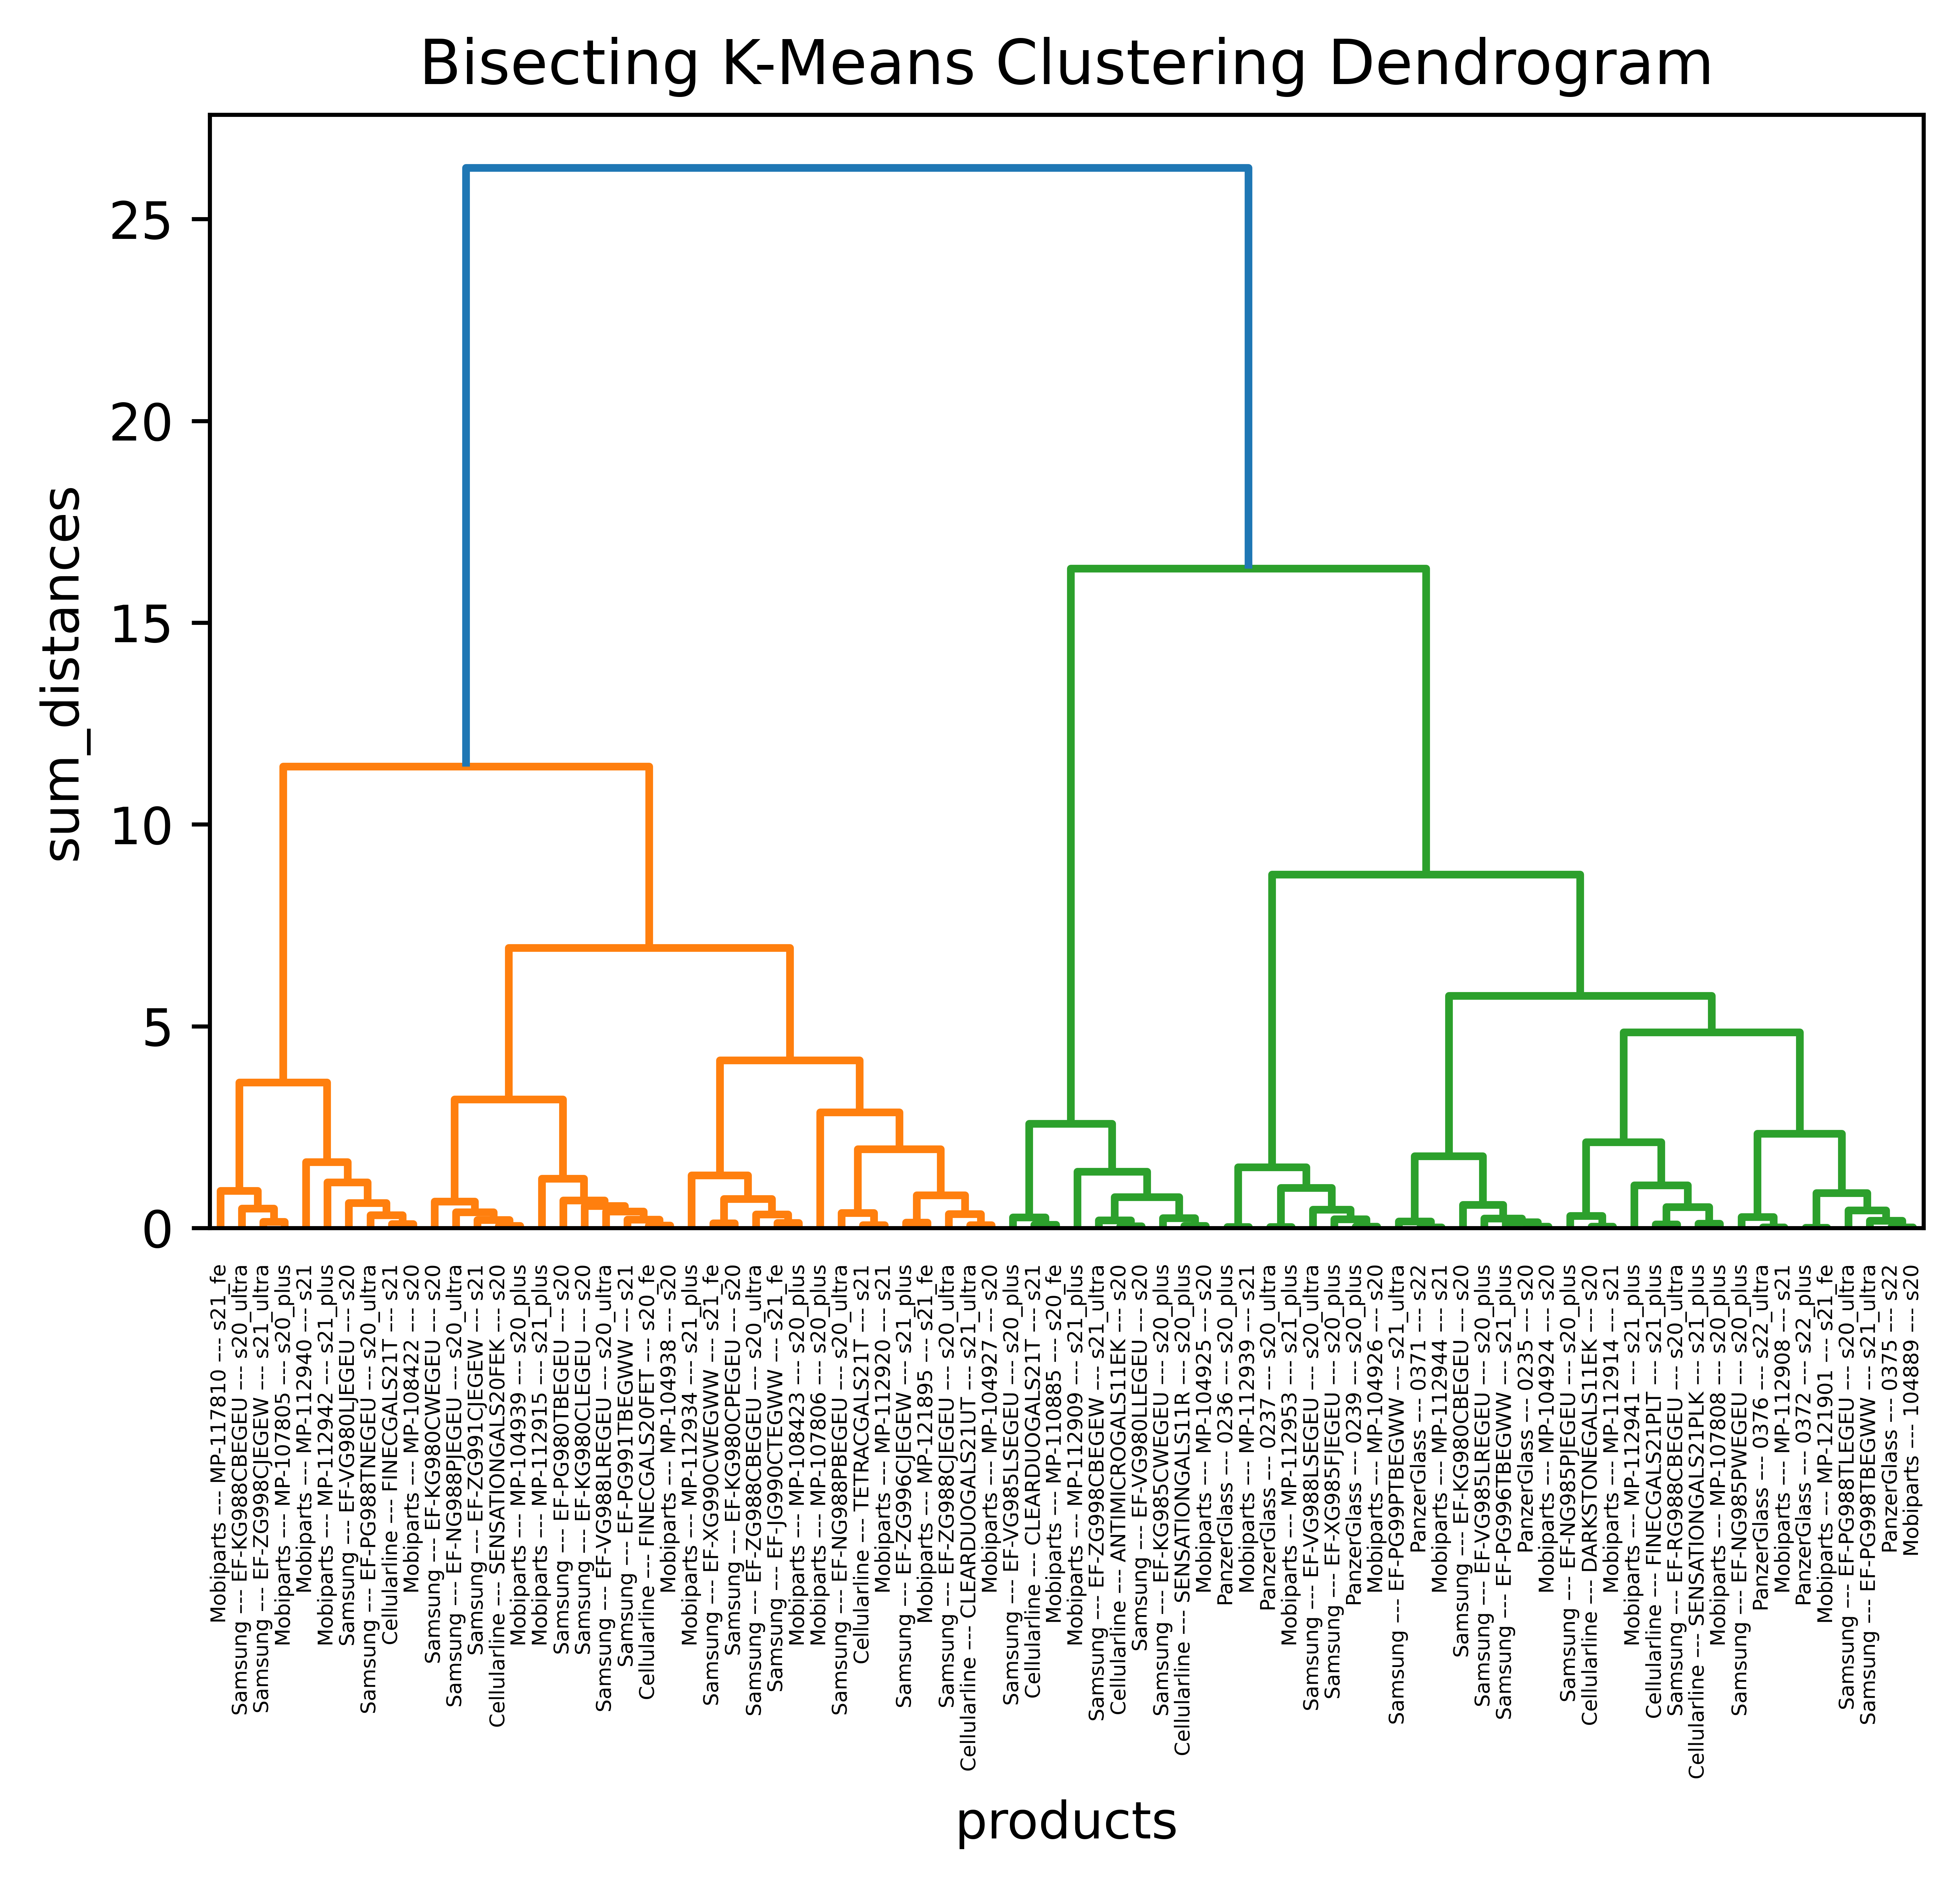

In [64]:
plt.figure(dpi=1000)
plt.title('Bisecting K-Means Clustering Dendrogram')
plt.xlabel('products')
plt.ylabel('sum_distances')
dendrogram(dendrogram_matrix, distance_sort="ascending", labels=labels, leaf_font_size=4)
plt.show()

In [80]:
df = pd.DataFrame({"want": labels_want, "got": labels_got})
df["count"] = 1
df.groupby(["want", "got"]).count().sort_values(["want", "count"], ascending=[True, False])

count
want      got       
s20       5        7
          6        7
          3        3
          2        1
s20_fe    1        1
          2        1
s20_plus  10       5
          0        4
          3        2
          4        2
          2        1
s20_ultra 4        6
          0        4
          3        1
s21       8        5
          2        4
          1        1
          7        1
s21_fe    1        2
          0        1
          6        1
          8        1
s21_plus  1        5
          7        3
          2        2
s21_ultra 7        4
          2        1
s22       9        2
s22_plus  9        1
s22_ultra 9        1